# Devoir 3 : Le modèle Leaky-Integrate-and-Fire

Dans ce devoir maison, vous allez approfondir tout ce que vous avez appris dans le TD sur le modèle 'Leaky Integrate-and-Fire'. Il est divisé en trois parties: 

La première partie est la partie du TD 3 que nous n'avons pas pu faire, j'y introduis la notion du *train de spike Poissonien* (en anglais *Poisson spike train*), une idéalisation de la décharge des neurones corticaux très répandue et utile. Vous n'avez rien *à faire* dans cette partie, mais elle vous sera utile pour comprendre --- et apprécier --- vos résultats de simulation dans la deuxième partie. Dans cette deuxième partie, il sera question de la courbe f-I du LIF en présence de bruit, et du CV du neurone en fonction des paramètres (courant moyen et amplitude du bruit).

Dans la troisième partie, vous allez à noveau étudier un LIF déterministe (sans bruit), avec un courant entrant qui dépend explicitement du temps. Cette troisième partie est une partie _**bonus**_ uniquement et vous n'êtes pas obligé.e.s de la faire pour obtenir tous les points sur ce devoir. Elle vous permettra néanmoins d'obtenir des points supplémentaires qui seront comptabilisés à la fin, par ex. pour compenser moins de points dans un autre devoir. Ou vous la faites purement pour le plaisir ! :)





## 1. Activité irrégulière des neurones corticaux

Dans le cortex, le timing des potentiels d'action successifs est très irrégulier. Le coefficient de variation des intervalles inter-spike est proche de 1, similaire à un processus de Poisson. Pour un processus de Poisson, la fonction de densité de probabilité pour le temps d'attente jusqu'au spike suivant est donnée par 
$$p(T) = f {\rm e}^{-f T}$$
Ici, $T$ est l'intervalle interspike, et $f$ est le taux de décharge. 

Ainsi, la densité de l'intervalle interspike pour un train de spike de Poisson homogène est une fonction exponentielle. Les intervalles d'interspike les plus probables sont courts et les intervalles longs ont une probabilité qui diminue de façon exponentielle en fonction de leur durée. Les histogrammes d'intervalles interspike peuvent être extraits des potentiels d'action en calculant la différence de temps entre tous les spikes successifs.  

Dans l'approximation la plus simple, le temps du spike suivant n'est pas du tout correlé avec le temps du spike précédant. (Evidemment, cela n'est pas vrai dès lors qu'il y a un temps refractaire, comme c'est biologiquement impossible qu'un neuron décharge par ex. deux fois d'affilé dans l'espace de moins d'une ms.)

### E1.1  Train de spike Poissonien

Générez un train de spikes Poissonien avec un taux de décharge $f = 10$ Hz. Calculez la moyenne et l'écart type des intervalles interspike (ISI). Vérifier que le coefficient de variation (CV = écart type/moyenne) est égal à 1. Tracez l'histogramme des ISI. Comment un train de spikes peut-il être généré à partir des ISIs? 


**Indice :** Les intervalles d'interspike d'un train de spikes Poissonien sont par définition distribués de façon exponentielle.  Un tel train de spikes peut donc être généré en tirant des nombres aléatoires de la distribution exponentielle et en les traitant comme des intervalles interspike. Utilisez la fonction numpy `np.random.exponential()` pour tirer les nombres de la distribution exponentielle. 


**Indice :** Vous pouvez créer et plotter des histograms avec la méthode `hist` d'un objet `Axes`, voir l'exemple ci-dessous. 


In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# S'informer sur la création de nombres 
# aléatoires suivant une distribution
# exponentielle
np.random.exponential?

In [3]:
# Tirer des nombres aléatoires représentant
# des ISI d'un train de spike Poissonien

rate = 10. # taux de décharge en Hz (spikes/s)

n = 1000 # nombre de ISI à tirer
isis = np.random.exponential(1/rate, size=n) 

# REMARQUE: puisque 'rate' est donné en 1/s,
# les ISI sont donnés en s

Text(0, 0.5, 'count')

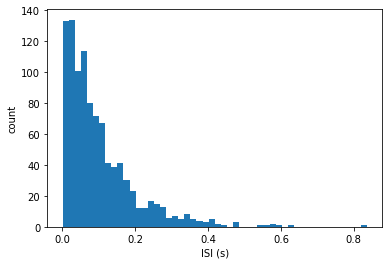

In [4]:
# Plottez l'histogramme des ISI
fig, ax = plt.subplots()

# --> utiliser la méthode 'hist'
# --> on l'a vu rapidement dans le TD
#ax.hist?
ax.hist(isis, bins=50)
ax.set_xlabel('ISI (s)')
ax.set_ylabel('count')

In [5]:
# Plottez le train de spike, c'est-à-dire
# les temps où des spikes ont été émis.
# ASTUCE : Utilisez ax.axvline
# pour plotter des lignes verticales
# d'un bord du graph à l'autre
# sans imposer des valeurs sur l'axe y

# les temps de spike sont données par les ISI
# relatif au premier spike... 

# version 1: 
spiketimes = [0]
for i in range(n):
    spiketimes.append(spiketimes[i]+isis[i])
    
# version 2:
# (presque équivalente sauf pour le premier spike)
#spiketimes = np.cumsum(isis)

Text(0.5, 0, 't (s)')

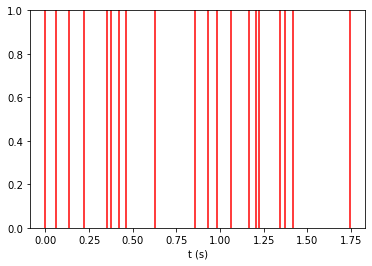

In [6]:
fig, ax = plt.subplots()
for ts in spiketimes[:20]:
    ax.axvline(ts, c='r')
ax.set_xlabel('t (s)')

In [7]:
# Verifiez que le CV est environ 1.

# calcul du CV (voir diapos du cours)
isi_mean = np.mean(isis) # ms
isi_std = np.std(isis) # ms
print('CV = ', isi_std/isi_mean)


CV =  0.983824567145236



## 2. Simulation du LIF avec bruit : courbe f-I et CV


Dans le dernier TD, nous avons déjà fait une vraie "simulation" d'activité neuronale avec le modèle de neurone vraisemblablement ***le plus simple et le plus puissant*** à la fois. 

***Simple*** car décrit par une équation assez simple qu'on peut facilement intégrer numériquement, et même résoudre analytiquement comme nous l'avons vu pour des courants simples. Simple aussi parce que dans ce modèle, un spike n'est finalement rien d'autre que le franchissement d'un seuil : simple sur le plan conceptuel. 

***Puissant*** enfin, car il se prète du coup parfaitement à l'étude mathématique même dans des situations plus complèxes (par ex. quand on considère des neurones qui reçoivent des courants fluctuants, plus réaliste pour les neurones dans le cortex), et parce qu'on peut très bien combiner beaucoup de tels neurones pour simuler des réseaux.

Dans cette exercise, je voudrais que vous appliquez et adaptez ce que nous avons vu vers la fin de la TD, afin d'assimiler et comprendre d'avantage l'exploit que nous avons réussi !

### Rappel : Dynamique sous-seuil du LIF sans et avec bruit 

Pour rappel, la dynamique **sous-seuil** (!) d'un neurone LIF _sans bruit_ est donnée par l'équation

$$\frac{dV}{dt} = \frac{1}{\tau}(E_L - V + RI )$$

Chaque fois que le potentiel $V$ franchit un seuil $V_{\rm seuil}$ par le bas, le modèle stipule qu'un PA est émis, et par la suite le potentiel est remis à sa valeur de "reset", $V\to V_{\rm reset}$.

Comme dans le TD3, nous considérons ici pour simplicité que $E_L=0$ mV (ou de manière équivalente, que $V$ est mésuré rélatif à $E_L$), ainsi que les paramètres suivants : $\tau=20$ ms et $R=1$ MOhm pour la dynamique sous-seuil, et $V_{\rm seuil}=20$ mV avec $V_{\rm reset}=0$ mV pour le mécanisme de décharge. 

Maintenant, en présence d'une bruit, l'équation devient

$$\frac{dV}{dt} = \frac{1}{\tau}(- V + RI+\sigma\sqrt{\tau}\xi),$$

($E_L=0$) avec la version discrétisée que nous avons vu dans le TD,

$$V_{i+1} = V_i + \Delta t \left[\frac{-V_i + RI}{\tau} + \sigma\sqrt{\frac{1}{\Delta t \tau}} \eta_i\right].$$

Ici, $\eta_i$ est désormais un simple nombre aléatoire tiré d'une distribution Gaussienne normalisée (moyenne 0, écart-type 1). 

### E2.1 :

Déterminez la courbe $f(I)$ pour des valeurs de $I$ de 10 à 30 nA,  `Ivalues = np.arange(10,30,0.1)`, en simulant le LIF avec l'équation donnée ci-dessus pour une durée de 5 s, `T = 5000 # ms`. Pour chacque valeur de $I$, déterminez également le CV.

**Indice :** Créez un array pour les taux de décharge et un array pour les CV avec autant d'entrées que vous avez de valeurs de I. Utilisez ce que nous avons fait dans le dernier TD pour simuler le LIF dans un boucle sur les courants, et écrivez le taux de décharge et le CV pour chaque I dans l'array respectif (comparez avec la solution type pour le dernier DM).

Plottez le résultat pour le taux de décharge pour $\sigma$ = 1 mV ensemble avec le résultat théorique sans bruit que nous avons calculé dans le TD. Si vous augmentez $\sigma$ encore d'avantage (par ex. $\sigma$ = 2 mV), quel changement de la courbe attendez vous ?

In [26]:
# Discretization of time
T = 5000 # ms
dt = 0.1
t = np.arange(0,T,dt)
nt = len(t)

In [45]:
# Definition of the dynamics
# (function returning dV/dt)

R = 1. # MOhm
tau = 20. # ms

def f(v,I):
    return (R*I - v)/tau

Vseuil = 20. # mV
Vreset = 0. # mV

In [28]:
sigma = 1.

Ivalues = np.arange(10,30,0.1)
nI = len(Ivalues)

rates = np.zeros(nI)
cvs = np.zeros(nI)

for iI, I in enumerate(Ivalues):
    #print('I = ', I)

    V = np.zeros(nt)
    V[0] = Vreset

    spiketimes = []
    
    # integration of LIF dynamics for a given current
    for i in range(nt-1):
        # deterministic part
        V[i+1] = V[i] + dt*f(V[i],I)

        # noisy contribution
        V[i+1] += np.sqrt(dt/tau)*sigma*np.random.normal()

        if V[i+1] > Vseuil:
            V[i+1] = Vreset
            spiketimes.append(t[i])
            
    # calculate the firing rate (in Hz, not in kHz)
    rates[iI] = 1000*len(spiketimes)/T 
    
    # calculate the CV
    isis = np.diff(spiketimes)
    cvs[iI] = np.std(isis)/np.mean(isis)
    

/Users/jranft/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in log
  This is separate from the ipykernel package so we can avoid doing imports until


Text(0, 0.5, 'f (Hz)')

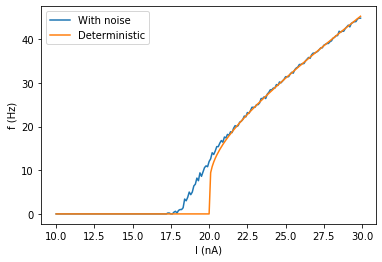

In [33]:
# analytical f-I curve without noise
def fI(I):
    T = tau*np.log((Vreset-R*I)/(Vseuil-R*I))
    return 1e3/T # in Hz

# determine the deterministic firing rate
# --> as those values of I where the LIF
# does not discharge/fire will give NaN 
# ('not a number'), change those to 0

rates_det = fI(Ivalues)
rates_det[np.isnan(rates_det)] = 0


# plot the firing rate
fig, ax = plt.subplots()
ax.plot(Ivalues, rates, label='With noise')
ax.plot(Ivalues, rates_det, label='Deterministic')
ax.legend()
ax.set_xlabel('I (nA)')
ax.set_ylabel('f (Hz)')

Plottez le CV en fonction du courant $I$. Avez-vous une explication (qui n'a pas besoin d'être précise) pour la dimunution du CV avec $I$ ? 

Plottez le potentiel de membrane pour une valeur de $I$ avec CV élevé (>0.5) et pour une valeur de CV faible (~0.1). Superposez les spikes selon l'exemple donné plus haut (basé sur les temps de spike).

Text(0, 0.5, 'CV')

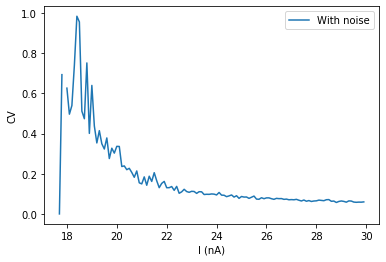

In [31]:
# plot the CVs
fig, ax = plt.subplots()
ax.plot(Ivalues, cvs, label='With noise')
ax.legend()
ax.set_xlabel('I (nA)')
ax.set_ylabel('CV')

Text(0, 0.5, 'V (mV)')

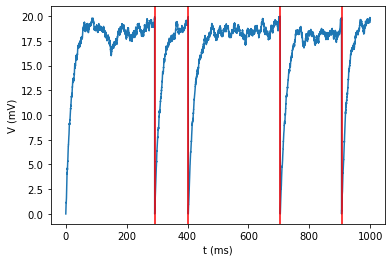

In [37]:
# CV ~ 0.5
I = 19.

# Discretization of time
T = 1000 # ms
dt = 0.1
t = np.arange(0,T,dt)
nt = len(t)

V = np.zeros(nt)
V[0] = Vreset

spiketimes = []

# integration of LIF dynamics for a given current
for i in range(nt-1):
    # deterministic part
    V[i+1] = V[i] + dt*f(V[i],I)

    # noisy contribution
    V[i+1] += np.sqrt(dt/tau)*sigma*np.random.normal()

    if V[i+1] > Vseuil:
        V[i+1] = Vreset
        spiketimes.append(t[i])
    
    
# plot of membrane potential and spikes
fig,ax = plt.subplots()
ax.plot(t, V)
for spiketime in spiketimes:
    ax.axvline(spiketime, c='r')
ax.set_xlabel('t (ms)')
ax.set_ylabel('V (mV)')

Text(0, 0.5, 'V (mV)')

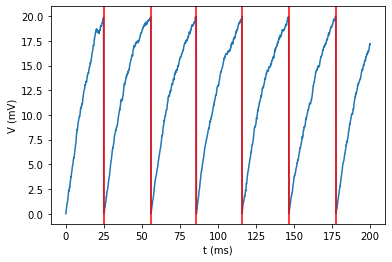

In [39]:
# CV ~ 0.5
I = 25.

# Discretization of time
T = 200 # ms
dt = 0.1
t = np.arange(0,T,dt)
nt = len(t)

V = np.zeros(nt)
V[0] = Vreset

spiketimes = []

# integration of LIF dynamics for a given current
for i in range(nt-1):
    # deterministic part
    V[i+1] = V[i] + dt*f(V[i],I)

    # noisy contribution
    V[i+1] += np.sqrt(dt/tau)*sigma*np.random.normal()

    if V[i+1] > Vseuil:
        V[i+1] = Vreset
        spiketimes.append(t[i])
    
    
# plot of membrane potential and spikes
fig,ax = plt.subplots()
ax.plot(t, V)
for spiketime in spiketimes:
    ax.axvline(spiketime, c='r')
ax.set_xlabel('t (ms)')
ax.set_ylabel('V (mV)')

La diminution du CV peut s'expliquer par le rôle diminué du bruit par rapport au courant moyen qui mène le neurone à la décharge (au-dessus du seuil). Plus que ce courant est important, moins le bruit (qui n'augmentne pas avec $I_0$)  peut modifier retarder ou avancer le moment où le potentiel franchi le seuil. Bien sûr, en-dessous du courant critique pour le LIF déterministe (dans notre cas 20 nA) à partir duquel seulement le LIF déterministe se met à décharger, la décharge est uniquement causé par des fluctuations et le CV est plutôt élevé.


## 3. LIF avec courant non-constant (BONUS)


Dans des simulations de réseau, ou pour des neurones plus réalistes, le courant n'est généralement pas constant - nous avons déjà étudié l'effet de fluctuations du courant autour d'une moyenne constante. 

Il peut y avoir des situations ou le courant "moyen" peut lui-même dépendre du temps. On va étudier ici le cas d'un neurone LIF **sans bruit** soumis à un courant qui est modulé par une sinusoïde, 

$$ I(t) = I_0 + \Delta I sin(2\pi f_{\rm mod} t)$$

Pour ce courant, choisissons $I_0=21$ nA, ce qui est un courant moyen au-dessus du seuil, et $\Delta I=2$ nA. Tous les autres paramètres sont inchangés.  

Pour la fréquence de modulation $f_{\rm mod}$, considerez les trois cas $f_{\rm mod}=2$ Hz, $f_{\rm mod}=20$ Hz, et $f_{\rm mod}=200$ Hz ; utilisez la condition initiale $V(t=0) = 0$.

**Attention 1 :** 1 Hz = 1/s. Pour calculer le produit $f_{\rm mod} t$, il faut d'abord exprimer la fréquence en kHz  si le temps est exprimé en ms (puisque 1 ms * 1kHz = 1), c'est-à-dire diviser $f_{\rm mod}$ par 1000. 

**Attention 2 :** La dynamique sous-seuil est toujours donnée par l'équation $\frac{dV}{dt} = \frac{1}{\tau}[E_L - V + RI(t)]$, mais $I$ dépend désormais explicitement du temps !

Déterminez $V(t)$ sur une durée de 2 s (2000 ms) et enregistrez les spikes pour les trois différentes valeurs de $f_{\rm mod}$. Plottez $V(t)$ avec les spikes superposés. Calculez les taux de décharge ainsi que les CV respectifs. Qu'est-ce que vous observez ?

In [51]:
# paramètres du courant
I0 = 21 # nA
DeltaI = 2 # nA

# proposition : définissez une 
# fonction qui retourne I en 
# fonction du temps
def I_of_t(t, f):
    return I0 + DeltaI * np.sin(2*np.pi*f*t)


# discrétisation du temps
T = 2000 # ms
dt = 0.1
t = np.arange(0,T,dt)
nt = len(t)



# calculate for three different frequencies

freqs = np.array([2,20,200]) # Hz

Vs = []
spikes = []

# boucle sur les fréquences de modulation
for freq in freqs:
    
    # initialisation potentiel
    V = np.zeros(nt)
    V[0] = Vreset
    
    spiketimes = []

    # integration of LIF dynamics for a given current
    for i in range(nt-1):
        # only deterministic evolution,
        # but with time-dependent current
        # (keep in mind that freqs have been
        # specified in Hz)
        V[i+1] = V[i] + dt*f(V[i],I_of_t(t[i], freq/1000))

        if V[i+1] > Vseuil:
            V[i+1] = Vreset
            spiketimes.append(t[i])
    
    Vs.append(V)
    spikes.append(spiketimes)
    

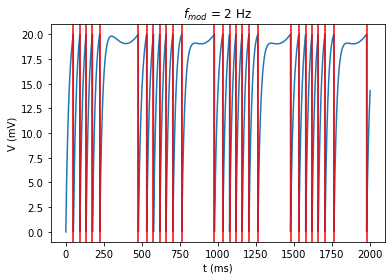

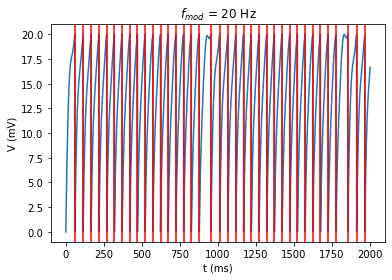

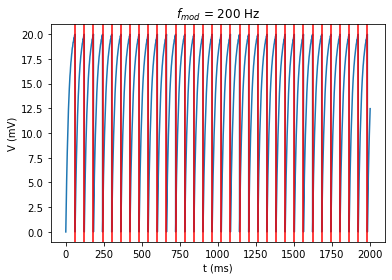

In [53]:
# plot of membrane potential and spikes
for i,freq in enumerate(freqs):
    fig,ax = plt.subplots()
    ax.set_title('$f_{mod}$ = %d Hz'%freq)
    ax.plot(t, Vs[i])
    for spiketime in spikes[i]:
        ax.axvline(spiketime, c='r')
    ax.set_xlabel('t (ms)')
    ax.set_ylabel('V (mV)')

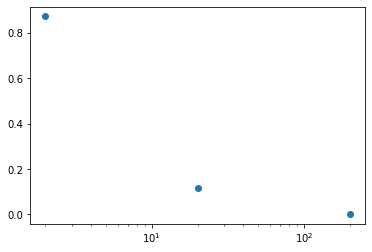

In [56]:
# calcul des CVs
cvs = []
for i,freq in enumerate(freqs):
    isis = np.diff(spikes[i])
    cvs.append(np.std(isis)/np.mean(isis))

fig, ax = plt.subplots()
ax.semilogx(freqs, cvs, 'o')


On constate qu'à basse fréquence de modulation, l'effet est le plus prononcé ; si la fréquence de modulation est beaucoup plus rapide que la décharge du neurone, elle n'a plus aucune effet.